# Implementation 2 of the Image Classfication Model

In [1]:
# Import the necessary libraries:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential# used for the model

### Dataset import:

In [2]:
# import the data from kaggle:
import opendatasets as od
import pandas

#download the data using a kaggle api:
dataset_path = "./large-image-dataset"#path to the data

### Load in the dataset:

In [3]:
#Loading the Data in a faster and more efficient manner:
files = os.listdir(dataset_path)#gather the path:
folder_path = os.path.join(dataset_path)#path to the images
#tf.keras.utils.image_dataset_from_directory??
data  = tf.keras.utils.image_dataset_from_directory(folder_path,image_size=(180,180))
print(type(data))

Found 19602 files belonging to 81 classes.
<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


### Preprocessing the data:

In [4]:
data = data.map(lambda x,y: (x/255, y))# tf function map to rescale the images
print(type(data))

<class 'tensorflow.python.data.ops.map_op._MapDataset'>


### Visualising the data:

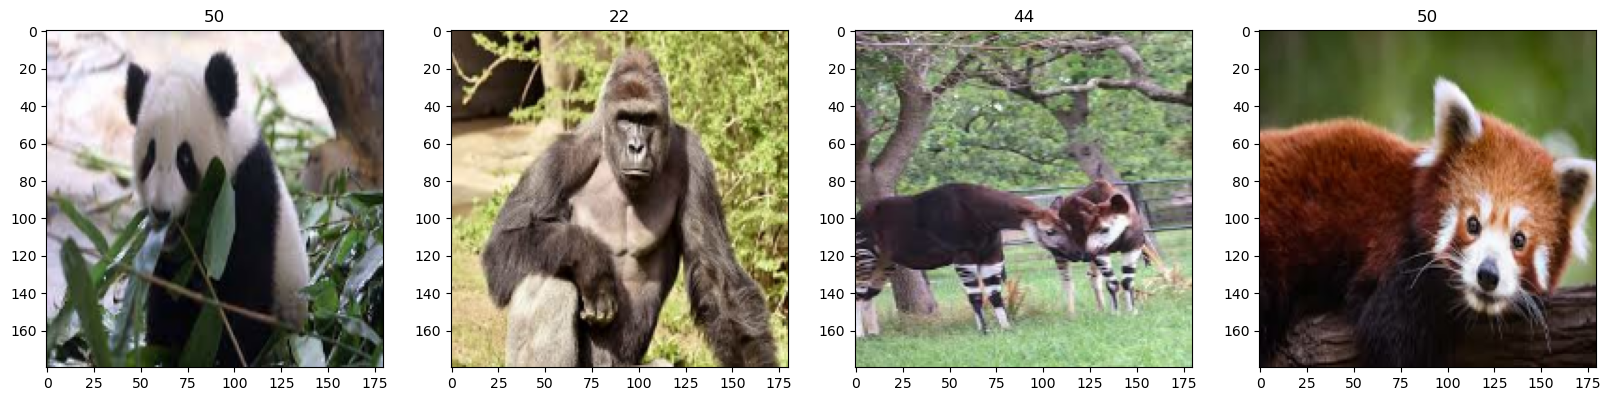

In [10]:
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()
# batch[0].shape
#visualise the data:
fig, axis = plt.subplots(ncols=4, figsize=(20, 20))
batch_images = batch[0][:4]
batch_labels = batch[1]

for idx in range(4):
    axis[idx].imshow(batch_images[idx])
    axis[idx].title.set_text(batch_labels[idx])

### Split up the data:

In [6]:
print(batch[0].max())
print(batch[0].min())

#Split the data:
print("Length: ",len(data))
#Size for each batch: (70% train, 15% validation, 15% test)
train_size = round(len(data) * 0.7)
validation_size = round(len(data)*0.2)
test_size = len(data) - train_size - validation_size
print(train_size,validation_size,test_size)

1.0
0.0
Length:  613
429 123 61


In [7]:
#Alocate the Batches to the data:
train_data = data.take(train_size)
val_data = data.skip(train_size).take(validation_size)
test_data = data.skip(train_size+validation_size).take(test_size)

print(len(train_data))

429


In [11]:
training_data_iterator = train_data.as_numpy_iterator()
batch = training_data_iterator.next()

### Data augmentation:

In [12]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
])

# Function to apply data augmentation to each batch
def apply_data_augmentation(images, labels):
    # Unpack the batch into images and labels

    augmented_images = data_augmentation(images)

    # Return a new dataset
    augmented_batch = (augmented_images, labels)
    
    return augmented_batch

In [13]:
train_data_augmented = train_data.map(apply_data_augmentation)

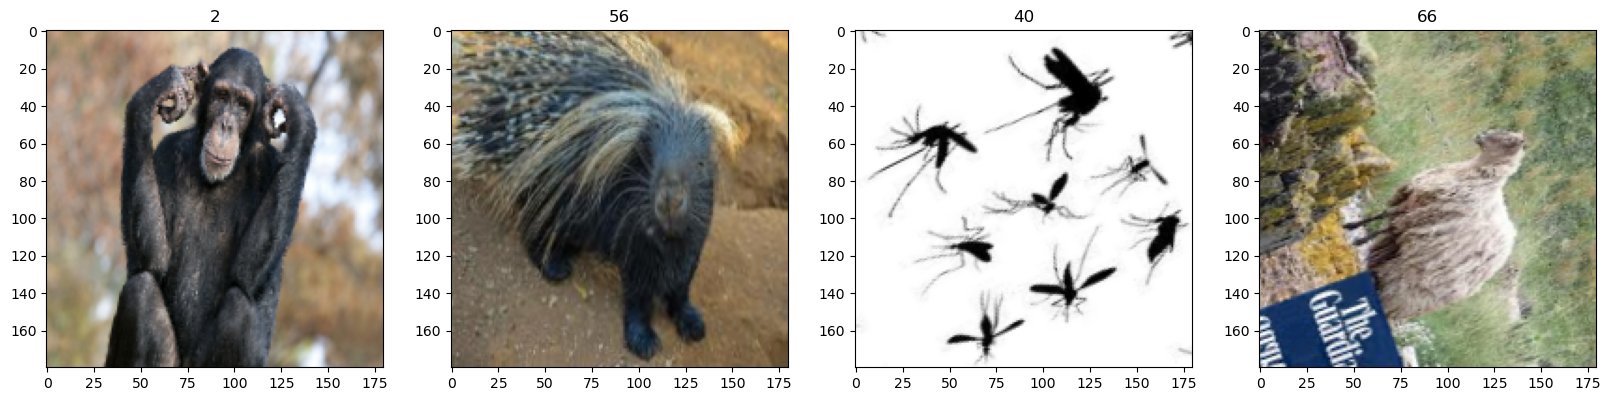

In [16]:
training_batch = train_data_augmented.as_numpy_iterator().next()

#visualise the data:
fig, axis = plt.subplots(ncols=4, figsize=(20, 20))
batch_images = training_batch[0][:4]
batch_labels = training_batch[1]

for idx in range(4):
    axis[idx].imshow(batch_images[idx])
    axis[idx].title.set_text(batch_labels[idx])

In [15]:
train_data = train_data.concatenate(train_data_augmented)

len(train_data)

858

### Training set data distribution:

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
train_class_counts = Counter()

for _, labels in train_data:
    train_class_counts.update(labels.numpy())
    

In [ ]:
#Bar chart for the training set
plt.figure(figsize=(15, 5))
plt.bar(train_class_counts.keys(), train_class_counts.values())
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Training Set Label Distribution')
plt.show()

### Validation Set data Distribution:

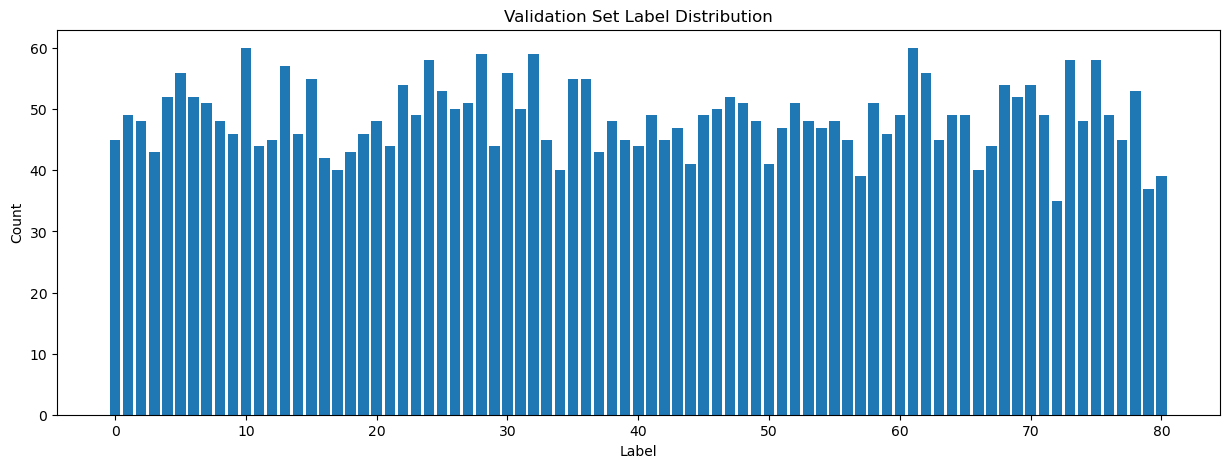

In [41]:

validation_class_counts = Counter()

for _, labels in val_data:
    validation_class_counts.update(labels.numpy())

#bar chart for the validation set
plt.figure(figsize=(15, 5))
plt.bar(validation_class_counts.keys(), validation_class_counts.values())
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Validation Set Label Distribution')
plt.show()



### Test Set Data Distribution

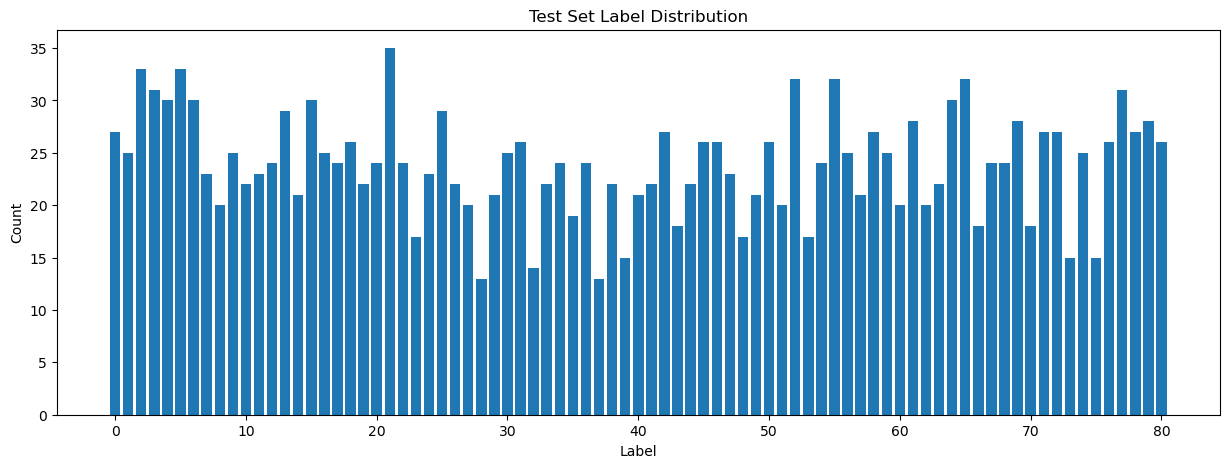

In [42]:
test_class_counter = Counter()

for _, labels in test_data:
    test_class_counter.update(labels.numpy())

#bar chart for the test set
plt.figure(figsize=(15, 5))
plt.bar(test_class_counter.keys(), test_class_counter.values())
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Test Set Label Distribution')
plt.show()

### Training the Network

In [13]:
#import the relative layers
from tensorflow.keras.models import Sequential# used for the model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation

In [18]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)))
model.add(MaxPooling2D((2, 2)))#reduce dimentions of the input

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))#reduce dimentions of the input

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))#reduce dimentions of the input

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))#reduce dimentions of the input

#Flatten results:
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))#fully connected layers
model.add(Dense(81, activation='softmax'))#fully connected layers and output



In [21]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 20, 20, 64)       

In [59]:
history = model.fit(train_data, epochs=25, validation_data=val_data)

Epoch 1/25
858/858 [==============================] - 709s 825ms/step - loss: 4.1362 - accuracy: 0.0502 - val_loss: 3.9120 - val_accuracy: 0.0912
Epoch 2/25
858/858 [==============================] - 705s 819ms/step - loss: 3.7175 - accuracy: 0.1210 - val_loss: 3.5993 - val_accuracy: 0.1466
Epoch 3/25
858/858 [==============================] - 735s 855ms/step - loss: 3.3917 - accuracy: 0.1849 - val_loss: 3.4287 - val_accuracy: 0.1966
Epoch 4/25
858/858 [==============================] - 713s 830ms/step - loss: 3.1162 - accuracy: 0.2414 - val_loss: 3.3754 - val_accuracy: 0.2116
Epoch 5/25
858/858 [==============================] - ETA: 0s - loss: 2.8787 - accuracy: 0.2879

KeyboardInterrupt: 

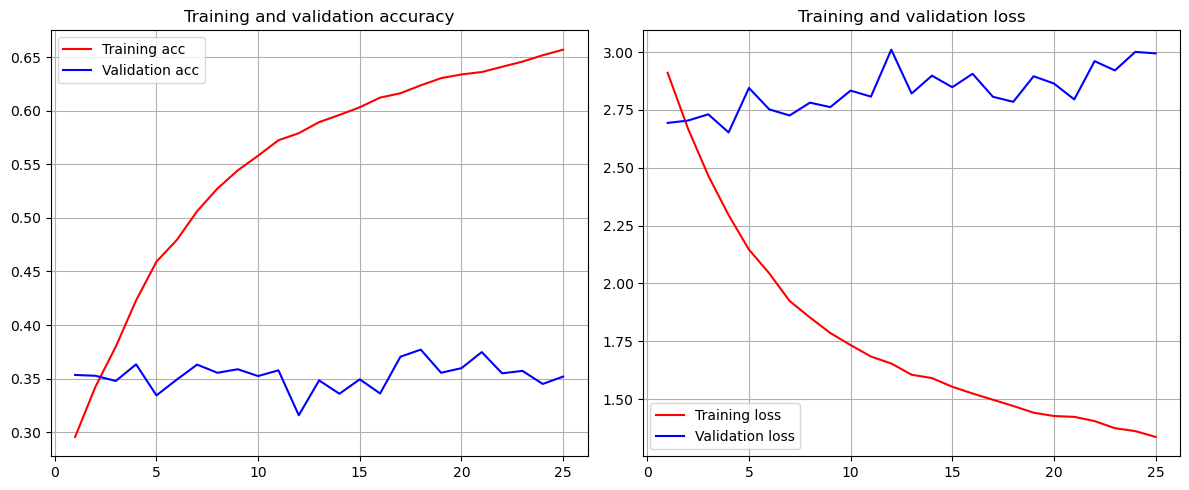

In [56]:
def visualize(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    axs[0].plot(epochs, acc, 'r', label='Training acc')
    axs[0].plot(epochs, val_acc, 'b', label='Validation acc')
    axs[0].set_title('Training and validation accuracy')
    axs[0].grid(True)
    axs[0].legend()
    
    axs[1].plot(epochs, loss, 'r', label='Training loss')
    axs[1].plot(epochs, val_loss, 'b', label='Validation loss')
    axs[1].set_title('Training and validation loss')
    axs[1].grid(True)
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()
visualize(history)

## Loading and Saving Weights:

In [32]:
model.save_weights('model_impl_one.h5')# To save the weights of the model

In [26]:
model.load_weights('model_impl_one.h5')# To load the weights of the model

### Retraining the Model form loaded Weights:

In [28]:
history = model.fit(train_data, epochs=25, validation_data=val_data)

Epoch 1/25
858/858 [==============================] - 602s 700ms/step - loss: 2.9107 - accuracy: 0.2956 - val_loss: 2.6939 - val_accuracy: 0.3534
Epoch 2/25
858/858 [==============================] - 675s 785ms/step - loss: 2.6698 - accuracy: 0.3424 - val_loss: 2.7039 - val_accuracy: 0.3526
Epoch 3/25
858/858 [==============================] - 691s 804ms/step - loss: 2.4659 - accuracy: 0.3798 - val_loss: 2.7309 - val_accuracy: 0.3478
Epoch 4/25
858/858 [==============================] - 693s 806ms/step - loss: 2.2954 - accuracy: 0.4230 - val_loss: 2.6527 - val_accuracy: 0.3633
Epoch 5/25
858/858 [==============================] - 694s 807ms/step - loss: 2.1464 - accuracy: 0.4591 - val_loss: 2.8450 - val_accuracy: 0.3343
Epoch 6/25
858/858 [==============================] - 665s 773ms/step - loss: 2.0437 - accuracy: 0.4793 - val_loss: 2.7523 - val_accuracy: 0.3491
Epoch 7/25
858/858 [==============================] - 660s 768ms/step - loss: 1.9244 - accuracy: 0.5062 - val_loss: 2.7260 -

In [30]:
test_results = model.evaluate(test_data)

# Print the test accuracy and loss
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])

61/61 [==============================] - 66s 177ms/step - loss: 3.0008 - accuracy: 0.3235
Test Loss: 3.000786066055298
Test Accuracy: 0.3235294222831726


## Model's Performance for each Animal:

In [54]:
for images, true_labels in test_data:
    # Get model predictions for the batch
    predictions_probabilities = model.predict(images)
    
    #Convert probabilities to class predictions
    predicted_classes = np.argmax(predictions_probabilities, axis=1)
    
    for i in range(len(true_labels)):
        true_label = class_names[true_labels[i]] # Convert true label index to class name
        predicted_class = class_names[predicted_classes[i]] # Convert predicted class index to class name
        prediction_prob = predictions_probabilities[i, predicted_classes[i]] # Probability of the predicted class
        
        print(f"Example {i + 1}:")
        print(f"Actual Label: {true_label}")
        print(f"Predicted Label: {predicted_class}")
        print(f"Prediction Probability: {prediction_prob * 100:.2f}%")
        print("=" * 40)


1/1 [==============================] - 0s 247ms/step
Example 1:
Actual Label: wombat
Predicted Label: panda
Prediction Probability: 29.73%
Example 2:
Actual Label: sheep
Predicted Label: penguin
Prediction Probability: 30.50%
Example 3:
Actual Label: lobster
Predicted Label: ladybugs
Prediction Probability: 21.23%
Example 4:
Actual Label: fly
Predicted Label: hornbill
Prediction Probability: 11.23%
Example 5:
Actual Label: seahorse
Predicted Label: seahorse
Prediction Probability: 73.69%
Example 6:
Actual Label: owl
Predicted Label: jellyfish
Prediction Probability: 40.64%
Example 7:
Actual Label: raccoon
Predicted Label: raccoon
Prediction Probability: 68.12%
Example 8:
Actual Label: mosquito
Predicted Label: seahorse
Prediction Probability: 40.74%
Example 9:
Actual Label: mouse
Predicted Label: porcupine
Prediction Probability: 9.27%
Example 10:
Actual Label: starfish
Predicted Label: leopard
Prediction Probability: 18.03%
Example 11:
Actual Label: jellyfish
Predicted Label: swan
Pre

1/1 [==============================] - 0s 149ms/step
Example 1:
Actual Label: moth
Predicted Label: moth
Prediction Probability: 99.79%
Example 2:
Actual Label: caterpillar
Predicted Label: caterpillar
Prediction Probability: 14.08%
Example 3:
Actual Label: eagle
Predicted Label: eagle
Prediction Probability: 31.03%
Example 4:
Actual Label: okapi
Predicted Label: owl
Prediction Probability: 24.86%
Example 5:
Actual Label: cat
Predicted Label: goat
Prediction Probability: 31.49%
Example 6:
Actual Label: dolphin
Predicted Label: whale
Prediction Probability: 43.90%
Example 7:
Actual Label: hornbill
Predicted Label: penguin
Prediction Probability: 21.03%
Example 8:
Actual Label: hedgehog
Predicted Label: hedgehog
Prediction Probability: 94.65%
Example 9:
Actual Label: leopard
Predicted Label: leopard
Prediction Probability: 54.82%
Example 10:
Actual Label: koala
Predicted Label: elephant
Prediction Probability: 19.37%
Example 11:
Actual Label: eagle
Predicted Label: elephant
Prediction Pr

1/1 [==============================] - 0s 147ms/step
Example 1:
Actual Label: zebra
Predicted Label: zebra
Prediction Probability: 99.58%
Example 2:
Actual Label: pigeon
Predicted Label: whale
Prediction Probability: 31.50%
Example 3:
Actual Label: sheep
Predicted Label: squirrel
Prediction Probability: 46.78%
Example 4:
Actual Label: otter
Predicted Label: sparrow
Prediction Probability: 11.60%
Example 5:
Actual Label: mouse
Predicted Label: mouse
Prediction Probability: 67.11%
Example 6:
Actual Label: seal
Predicted Label: cat
Prediction Probability: 30.79%
Example 7:
Actual Label: pelecaniformes
Predicted Label: zebra
Prediction Probability: 37.63%
Example 8:
Actual Label: sandpiper
Predicted Label: sandpiper
Prediction Probability: 33.36%
Example 9:
Actual Label: hare
Predicted Label: duck
Prediction Probability: 40.66%
Example 10:
Actual Label: eagle
Predicted Label: crow
Prediction Probability: 7.50%
Example 11:
Actual Label: ox
Predicted Label: crab
Prediction Probability: 77.90

1/1 [==============================] - 0s 147ms/step
Example 1:
Actual Label: possum
Predicted Label: possum
Prediction Probability: 61.54%
Example 2:
Actual Label: owl
Predicted Label: cat
Prediction Probability: 14.18%
Example 3:
Actual Label: sheep
Predicted Label: sheep
Prediction Probability: 16.31%
Example 4:
Actual Label: flamingo
Predicted Label: hummingbird
Prediction Probability: 50.11%
Example 5:
Actual Label: rhinoceros
Predicted Label: rhinoceros
Prediction Probability: 9.46%
Example 6:
Actual Label: koala
Predicted Label: coyote
Prediction Probability: 16.44%
Example 7:
Actual Label: hornbill
Predicted Label: snake
Prediction Probability: 28.27%
Example 8:
Actual Label: orangutan
Predicted Label: cow
Prediction Probability: 8.23%
Example 9:
Actual Label: cockroach
Predicted Label: hornbill
Prediction Probability: 19.09%
Example 10:
Actual Label: woodpecker
Predicted Label: woodpecker
Prediction Probability: 97.57%
Example 11:
Actual Label: leopard
Predicted Label: porcupi

1/1 [==============================] - 0s 150ms/step
Example 1:
Actual Label: penguin
Predicted Label: penguin
Prediction Probability: 62.55%
Example 2:
Actual Label: lizard
Predicted Label: grasshopper
Prediction Probability: 78.71%
Example 3:
Actual Label: cow
Predicted Label: orangutan
Prediction Probability: 18.19%
Example 4:
Actual Label: pigeon
Predicted Label: pigeon
Prediction Probability: 91.95%
Example 5:
Actual Label: pelecaniformes
Predicted Label: eagle
Prediction Probability: 72.30%
Example 6:
Actual Label: jellyfish
Predicted Label: seal
Prediction Probability: 20.09%
Example 7:
Actual Label: raccoon
Predicted Label: turtle
Prediction Probability: 20.06%
Example 8:
Actual Label: flamingo
Predicted Label: pigeon
Prediction Probability: 73.65%
Example 9:
Actual Label: raccoon
Predicted Label: turtle
Prediction Probability: 8.68%
Example 10:
Actual Label: tiger
Predicted Label: tiger
Prediction Probability: 99.67%
Example 11:
Actual Label: deer
Predicted Label: kangaroo
Pre

1/1 [==============================] - 0s 135ms/step
Example 1:
Actual Label: dolphin
Predicted Label: cow
Prediction Probability: 6.25%
Example 2:
Actual Label: duck
Predicted Label: squid
Prediction Probability: 19.02%
Example 3:
Actual Label: duck
Predicted Label: hornbill
Prediction Probability: 32.79%
Example 4:
Actual Label: squid
Predicted Label: shark
Prediction Probability: 53.20%
Example 5:
Actual Label: ox
Predicted Label: turkey
Prediction Probability: 14.18%
Example 6:
Actual Label: moth
Predicted Label: oyster
Prediction Probability: 12.99%
Example 7:
Actual Label: otter
Predicted Label: wombat
Prediction Probability: 59.12%
Example 8:
Actual Label: chimpanzee
Predicted Label: hornbill
Prediction Probability: 76.65%
Example 9:
Actual Label: octopus
Predicted Label: dolphin
Prediction Probability: 74.50%
Example 10:
Actual Label: reindeer
Predicted Label: hornbill
Prediction Probability: 21.15%
Example 11:
Actual Label: hummingbird
Predicted Label: pelecaniformes
Predictio

1/1 [==============================] - 0s 147ms/step
Example 1:
Actual Label: whale
Predicted Label: parrot
Prediction Probability: 11.52%
Example 2:
Actual Label: hyena
Predicted Label: fox
Prediction Probability: 34.65%
Example 3:
Actual Label: turkey
Predicted Label: ladybugs
Prediction Probability: 24.55%
Example 4:
Actual Label: elephant
Predicted Label: flamingo
Prediction Probability: 47.58%
Example 5:
Actual Label: wolf
Predicted Label: tiger
Prediction Probability: 40.27%
Example 6:
Actual Label: caterpillar
Predicted Label: sparrow
Prediction Probability: 43.00%
Example 7:
Actual Label: sandpiper
Predicted Label: sandpiper
Prediction Probability: 91.19%
Example 8:
Actual Label: otter
Predicted Label: penguin
Prediction Probability: 15.40%
Example 9:
Actual Label: jellyfish
Predicted Label: caterpillar
Prediction Probability: 21.70%
Example 10:
Actual Label: crow
Predicted Label: crow
Prediction Probability: 80.68%
Example 11:
Actual Label: ox
Predicted Label: ox
Prediction Pr

1/1 [==============================] - 0s 149ms/step
Example 1:
Actual Label: goose
Predicted Label: sheep
Prediction Probability: 15.64%
Example 2:
Actual Label: starfish
Predicted Label: dragonfly
Prediction Probability: 20.72%
Example 3:
Actual Label: starfish
Predicted Label: starfish
Prediction Probability: 91.64%
Example 4:
Actual Label: crow
Predicted Label: crow
Prediction Probability: 56.56%
Example 5:
Actual Label: eagle
Predicted Label: penguin
Prediction Probability: 31.60%
Example 6:
Actual Label: hornbill
Predicted Label: hornbill
Prediction Probability: 38.22%
Example 7:
Actual Label: hedgehog
Predicted Label: hedgehog
Prediction Probability: 73.67%
Example 8:
Actual Label: owl
Predicted Label: tiger
Prediction Probability: 44.88%
Example 9:
Actual Label: flamingo
Predicted Label: mouse
Prediction Probability: 28.34%
Example 10:
Actual Label: owl
Predicted Label: lion
Prediction Probability: 8.57%
Example 11:
Actual Label: seal
Predicted Label: sandpiper
Prediction Proba

1/1 [==============================] - 0s 163ms/step
Example 1:
Actual Label: hamster
Predicted Label: mouse
Prediction Probability: 23.27%
Example 2:
Actual Label: donkey
Predicted Label: donkey
Prediction Probability: 22.76%
Example 3:
Actual Label: goat
Predicted Label: rhinoceros
Prediction Probability: 25.58%
Example 4:
Actual Label: horse
Predicted Label: cow
Prediction Probability: 20.54%
Example 5:
Actual Label: panda
Predicted Label: panda
Prediction Probability: 81.53%
Example 6:
Actual Label: starfish
Predicted Label: kangaroo
Prediction Probability: 6.20%
Example 7:
Actual Label: mouse
Predicted Label: mouse
Prediction Probability: 24.96%
Example 8:
Actual Label: mouse
Predicted Label: orangutan
Prediction Probability: 23.39%
Example 9:
Actual Label: raccoon
Predicted Label: wolf
Prediction Probability: 15.70%
Example 10:
Actual Label: whale
Predicted Label: whale
Prediction Probability: 93.39%
Example 11:
Actual Label: deer
Predicted Label: pelecaniformes
Prediction Probab

1/1 [==============================] - 0s 150ms/step
Example 1:
Actual Label: seahorse
Predicted Label: parrot
Prediction Probability: 35.80%
Example 2:
Actual Label: hedgehog
Predicted Label: zebra
Prediction Probability: 65.48%
Example 3:
Actual Label: tiger
Predicted Label: leopard
Prediction Probability: 99.70%
Example 4:
Actual Label: sparrow
Predicted Label: pelecaniformes
Prediction Probability: 9.61%
Example 5:
Actual Label: cockroach
Predicted Label: ladybugs
Prediction Probability: 49.62%
Example 6:
Actual Label: otter
Predicted Label: sandpiper
Prediction Probability: 17.67%
Example 7:
Actual Label: owl
Predicted Label: starfish
Prediction Probability: 22.62%
Example 8:
Actual Label: seahorse
Predicted Label: cockroach
Prediction Probability: 22.58%
Example 9:
Actual Label: lion
Predicted Label: goat
Prediction Probability: 29.92%
Example 10:
Actual Label: cow
Predicted Label: penguin
Prediction Probability: 17.61%
Example 11:
Actual Label: woodpecker
Predicted Label: woodpe

1/1 [==============================] - 0s 167ms/step
Example 1:
Actual Label: possum
Predicted Label: possum
Prediction Probability: 59.22%
Example 2:
Actual Label: pigeon
Predicted Label: mouse
Prediction Probability: 18.13%
Example 3:
Actual Label: jellyfish
Predicted Label: jellyfish
Prediction Probability: 94.30%
Example 4:
Actual Label: dolphin
Predicted Label: otter
Prediction Probability: 8.06%
Example 5:
Actual Label: hare
Predicted Label: hedgehog
Prediction Probability: 64.51%
Example 6:
Actual Label: snake
Predicted Label: zebra
Prediction Probability: 28.86%
Example 7:
Actual Label: sparrow
Predicted Label: orangutan
Prediction Probability: 18.47%
Example 8:
Actual Label: goldfish
Predicted Label: goldfish
Prediction Probability: 96.21%
Example 9:
Actual Label: leopard
Predicted Label: leopard
Prediction Probability: 72.89%
Example 10:
Actual Label: elephant
Predicted Label: elephant
Prediction Probability: 65.40%
Example 11:
Actual Label: pig
Predicted Label: oyster
Predic

1/1 [==============================] - 0s 136ms/step
Example 1:
Actual Label: dog
Predicted Label: horse
Prediction Probability: 26.71%
Example 2:
Actual Label: grasshopper
Predicted Label: zebra
Prediction Probability: 27.40%
Example 3:
Actual Label: mosquito
Predicted Label: duck
Prediction Probability: 17.30%
Example 4:
Actual Label: duck
Predicted Label: otter
Prediction Probability: 16.34%
Example 5:
Actual Label: dog
Predicted Label: panda
Prediction Probability: 43.63%
Example 6:
Actual Label: pig
Predicted Label: penguin
Prediction Probability: 18.11%
Example 7:
Actual Label: hyena
Predicted Label: snake
Prediction Probability: 48.84%
Example 8:
Actual Label: fox
Predicted Label: fox
Prediction Probability: 91.16%
Example 9:
Actual Label: crow
Predicted Label: penguin
Prediction Probability: 16.69%
Example 10:
Actual Label: shark
Predicted Label: whale
Prediction Probability: 58.28%
Example 11:
Actual Label: gorilla
Predicted Label: leopard
Prediction Probability: 8.55%
Example

1/1 [==============================] - 0s 140ms/step
Example 1:
Actual Label: raccoon
Predicted Label: flamingo
Prediction Probability: 20.55%
Example 2:
Actual Label: goldfish
Predicted Label: cow
Prediction Probability: 29.45%
Example 3:
Actual Label: orangutan
Predicted Label: koala
Prediction Probability: 64.06%
Example 4:
Actual Label: woodpecker
Predicted Label: woodpecker
Prediction Probability: 87.17%
Example 5:
Actual Label: dog
Predicted Label: chimpanzee
Prediction Probability: 22.34%
Example 6:
Actual Label: tiger
Predicted Label: owl
Prediction Probability: 28.68%
Example 7:
Actual Label: mosquito
Predicted Label: cockroach
Prediction Probability: 17.85%
Example 8:
Actual Label: parrot
Predicted Label: hamster
Prediction Probability: 84.73%
Example 9:
Actual Label: hippopotamus
Predicted Label: hippopotamus
Prediction Probability: 8.58%
Example 10:
Actual Label: coyote
Predicted Label: coyote
Prediction Probability: 38.95%
Example 11:
Actual Label: fox
Predicted Label: sta

1/1 [==============================] - 0s 142ms/step
Example 1:
Actual Label: pelecaniformes
Predicted Label: pigeon
Prediction Probability: 18.03%
Example 2:
Actual Label: lizard
Predicted Label: fox
Prediction Probability: 11.22%
Example 3:
Actual Label: turkey
Predicted Label: sheep
Prediction Probability: 43.45%
Example 4:
Actual Label: donkey
Predicted Label: donkey
Prediction Probability: 72.99%
Example 5:
Actual Label: hyena
Predicted Label: ox
Prediction Probability: 13.63%
Example 6:
Actual Label: coyote
Predicted Label: tiger
Prediction Probability: 25.94%
Example 7:
Actual Label: cow
Predicted Label: ox
Prediction Probability: 20.27%
Example 8:
Actual Label: sparrow
Predicted Label: sparrow
Prediction Probability: 74.70%
Example 9:
Actual Label: tiger
Predicted Label: tiger
Prediction Probability: 99.58%
Example 10:
Actual Label: zebra
Predicted Label: zebra
Prediction Probability: 81.37%
Example 11:
Actual Label: hornbill
Predicted Label: okapi
Prediction Probability: 30.92

1/1 [==============================] - 0s 134ms/step
Example 1:
Actual Label: cockroach
Predicted Label: snake
Prediction Probability: 73.99%
Example 2:
Actual Label: swan
Predicted Label: mouse
Prediction Probability: 19.10%
Example 3:
Actual Label: snake
Predicted Label: penguin
Prediction Probability: 45.26%
Example 4:
Actual Label: lion
Predicted Label: kangaroo
Prediction Probability: 12.54%
Example 5:
Actual Label: starfish
Predicted Label: penguin
Prediction Probability: 16.53%
Example 6:
Actual Label: wombat
Predicted Label: cat
Prediction Probability: 22.42%
Example 7:
Actual Label: penguin
Predicted Label: penguin
Prediction Probability: 68.80%
Example 8:
Actual Label: goat
Predicted Label: cow
Prediction Probability: 23.24%
Example 9:
Actual Label: duck
Predicted Label: duck
Prediction Probability: 69.92%
Example 10:
Actual Label: turkey
Predicted Label: leopard
Prediction Probability: 88.48%
Example 11:
Actual Label: lobster
Predicted Label: leopard
Prediction Probability: 

1/1 [==============================] - 0s 152ms/step
Example 1:
Actual Label: kangaroo
Predicted Label: sparrow
Prediction Probability: 44.11%
Example 2:
Actual Label: koala
Predicted Label: wombat
Prediction Probability: 28.90%
Example 3:
Actual Label: swan
Predicted Label: possum
Prediction Probability: 71.83%
Example 4:
Actual Label: woodpecker
Predicted Label: zebra
Prediction Probability: 43.39%
Example 5:
Actual Label: jellyfish
Predicted Label: mouse
Prediction Probability: 64.24%
Example 6:
Actual Label: lizard
Predicted Label: leopard
Prediction Probability: 25.10%
Example 7:
Actual Label: duck
Predicted Label: reindeer
Prediction Probability: 20.21%
Example 8:
Actual Label: goldfish
Predicted Label: goldfish
Prediction Probability: 77.17%
Example 9:
Actual Label: koala
Predicted Label: koala
Prediction Probability: 48.69%
Example 10:
Actual Label: lizard
Predicted Label: elephant
Prediction Probability: 30.41%
Example 11:
Actual Label: chimpanzee
Predicted Label: chimpanzee
P

1/1 [==============================] - 0s 186ms/step
Example 1:
Actual Label: seahorse
Predicted Label: caterpillar
Prediction Probability: 62.99%
Example 2:
Actual Label: grasshopper
Predicted Label: ladybugs
Prediction Probability: 32.00%
Example 3:
Actual Label: raccoon
Predicted Label: raccoon
Prediction Probability: 87.70%
Example 4:
Actual Label: cow
Predicted Label: raccoon
Prediction Probability: 24.17%
Example 5:
Actual Label: hummingbird
Predicted Label: duck
Prediction Probability: 26.93%
Example 6:
Actual Label: seahorse
Predicted Label: seahorse
Prediction Probability: 35.36%
Example 7:
Actual Label: pelecaniformes
Predicted Label: penguin
Prediction Probability: 47.28%
Example 8:
Actual Label: octopus
Predicted Label: leopard
Prediction Probability: 28.30%
Example 9:
Actual Label: otter
Predicted Label: hyena
Prediction Probability: 21.99%
Example 10:
Actual Label: jellyfish
Predicted Label: jellyfish
Prediction Probability: 60.23%
Example 11:
Actual Label: shark
Predicte

1/1 [==============================] - 0s 204ms/step
Example 1:
Actual Label: orangutan
Predicted Label: orangutan
Prediction Probability: 82.02%
Example 2:
Actual Label: starfish
Predicted Label: lobster
Prediction Probability: 61.04%
Example 3:
Actual Label: fox
Predicted Label: fox
Prediction Probability: 37.92%
Example 4:
Actual Label: hippopotamus
Predicted Label: penguin
Prediction Probability: 12.73%
Example 5:
Actual Label: flamingo
Predicted Label: sparrow
Prediction Probability: 50.58%
Example 6:
Actual Label: fox
Predicted Label: fox
Prediction Probability: 93.24%
Example 7:
Actual Label: koala
Predicted Label: leopard
Prediction Probability: 19.60%
Example 8:
Actual Label: starfish
Predicted Label: zebra
Prediction Probability: 28.68%
Example 9:
Actual Label: dog
Predicted Label: koala
Prediction Probability: 34.24%
Example 10:
Actual Label: pelecaniformes
Predicted Label: swan
Prediction Probability: 46.63%
Example 11:
Actual Label: woodpecker
Predicted Label: woodpecker
P

1/1 [==============================] - 0s 184ms/step
Example 1:
Actual Label: shark
Predicted Label: whale
Prediction Probability: 61.29%
Example 2:
Actual Label: chimpanzee
Predicted Label: turkey
Prediction Probability: 56.39%
Example 3:
Actual Label: hamster
Predicted Label: hamster
Prediction Probability: 39.39%
Example 4:
Actual Label: cockroach
Predicted Label: parrot
Prediction Probability: 22.56%
Example 5:
Actual Label: flamingo
Predicted Label: flamingo
Prediction Probability: 94.91%
Example 6:
Actual Label: dragonfly
Predicted Label: dragonfly
Prediction Probability: 35.90%
Example 7:
Actual Label: ladybugs
Predicted Label: ladybugs
Prediction Probability: 65.69%
Example 8:
Actual Label: elephant
Predicted Label: elephant
Prediction Probability: 14.01%
Example 9:
Actual Label: mouse
Predicted Label: penguin
Prediction Probability: 63.14%
Example 10:
Actual Label: pigeon
Predicted Label: lizard
Prediction Probability: 52.48%
Example 11:
Actual Label: ladybugs
Predicted Label:

1/1 [==============================] - 0s 180ms/step
Example 1:
Actual Label: grasshopper
Predicted Label: grasshopper
Prediction Probability: 22.51%
Example 2:
Actual Label: squid
Predicted Label: goldfish
Prediction Probability: 60.41%
Example 3:
Actual Label: tiger
Predicted Label: tiger
Prediction Probability: 74.18%
Example 4:
Actual Label: hare
Predicted Label: wolf
Prediction Probability: 25.79%
Example 5:
Actual Label: okapi
Predicted Label: okapi
Prediction Probability: 76.31%
Example 6:
Actual Label: dog
Predicted Label: chimpanzee
Prediction Probability: 42.61%
Example 7:
Actual Label: sparrow
Predicted Label: sandpiper
Prediction Probability: 17.69%
Example 8:
Actual Label: orangutan
Predicted Label: orangutan
Prediction Probability: 97.33%
Example 9:
Actual Label: cockroach
Predicted Label: fox
Prediction Probability: 31.87%
Example 10:
Actual Label: goat
Predicted Label: kangaroo
Prediction Probability: 37.83%
Example 11:
Actual Label: pelecaniformes
Predicted Label: swan

1/1 [==============================] - 0s 207ms/step
Example 1:
Actual Label: seal
Predicted Label: okapi
Prediction Probability: 13.17%
Example 2:
Actual Label: koala
Predicted Label: koala
Prediction Probability: 11.17%
Example 3:
Actual Label: woodpecker
Predicted Label: parrot
Prediction Probability: 13.88%
Example 4:
Actual Label: rat
Predicted Label: eagle
Prediction Probability: 31.34%
Example 5:
Actual Label: wombat
Predicted Label: zebra
Prediction Probability: 31.51%
Example 6:
Actual Label: parrot
Predicted Label: parrot
Prediction Probability: 21.32%
Example 7:
Actual Label: cockroach
Predicted Label: cat
Prediction Probability: 9.61%
Example 8:
Actual Label: ox
Predicted Label: goose
Prediction Probability: 46.11%
Example 9:
Actual Label: hamster
Predicted Label: hamster
Prediction Probability: 86.19%
Example 10:
Actual Label: fox
Predicted Label: fox
Prediction Probability: 92.59%
Example 11:
Actual Label: whale
Predicted Label: dolphin
Prediction Probability: 36.29%
Exam

1/1 [==============================] - 0s 157ms/step
Example 1:
Actual Label: elephant
Predicted Label: elephant
Prediction Probability: 32.50%
Example 2:
Actual Label: fly
Predicted Label: lobster
Prediction Probability: 24.28%
Example 3:
Actual Label: tiger
Predicted Label: leopard
Prediction Probability: 91.20%
Example 4:
Actual Label: orangutan
Predicted Label: panda
Prediction Probability: 37.28%
Example 5:
Actual Label: wolf
Predicted Label: wolf
Prediction Probability: 74.80%
Example 6:
Actual Label: deer
Predicted Label: lion
Prediction Probability: 33.23%
Example 7:
Actual Label: pelecaniformes
Predicted Label: seahorse
Prediction Probability: 26.99%
Example 8:
Actual Label: flamingo
Predicted Label: dog
Prediction Probability: 13.73%
Example 9:
Actual Label: whale
Predicted Label: eagle
Prediction Probability: 55.17%
Example 10:
Actual Label: hyena
Predicted Label: hyena
Prediction Probability: 45.26%
Example 11:
Actual Label: cockroach
Predicted Label: eagle
Prediction Proba

1/1 [==============================] - 0s 150ms/step
Example 1:
Actual Label: owl
Predicted Label: tiger
Prediction Probability: 8.56%
Example 2:
Actual Label: horse
Predicted Label: orangutan
Prediction Probability: 34.06%
Example 3:
Actual Label: flamingo
Predicted Label: grasshopper
Prediction Probability: 26.89%
Example 4:
Actual Label: dolphin
Predicted Label: shark
Prediction Probability: 34.14%
Example 5:
Actual Label: fly
Predicted Label: fly
Prediction Probability: 52.35%
Example 6:
Actual Label: fly
Predicted Label: elephant
Prediction Probability: 16.22%
Example 7:
Actual Label: oyster
Predicted Label: leopard
Prediction Probability: 38.81%
Example 8:
Actual Label: reindeer
Predicted Label: reindeer
Prediction Probability: 75.74%
Example 9:
Actual Label: flamingo
Predicted Label: flamingo
Prediction Probability: 11.94%
Example 10:
Actual Label: ladybugs
Predicted Label: shark
Prediction Probability: 45.84%
Example 11:
Actual Label: fox
Predicted Label: hamster
Prediction Pro

1/1 [==============================] - 0s 158ms/step
Example 1:
Actual Label: mouse
Predicted Label: mouse
Prediction Probability: 16.57%
Example 2:
Actual Label: crab
Predicted Label: ox
Prediction Probability: 35.44%
Example 3:
Actual Label: coyote
Predicted Label: kangaroo
Prediction Probability: 33.78%
Example 4:
Actual Label: coyote
Predicted Label: sandpiper
Prediction Probability: 49.74%
Example 5:
Actual Label: mosquito
Predicted Label: mosquito
Prediction Probability: 99.76%
Example 6:
Actual Label: goose
Predicted Label: swan
Prediction Probability: 12.32%
Example 7:
Actual Label: tiger
Predicted Label: tiger
Prediction Probability: 36.57%
Example 8:
Actual Label: lion
Predicted Label: lion
Prediction Probability: 99.03%
Example 9:
Actual Label: rat
Predicted Label: crow
Prediction Probability: 32.79%
Example 10:
Actual Label: hedgehog
Predicted Label: hedgehog
Prediction Probability: 81.07%
Example 11:
Actual Label: shark
Predicted Label: pelecaniformes
Prediction Probabilit

1/1 [==============================] - 0s 134ms/step
Example 1:
Actual Label: chimpanzee
Predicted Label: chimpanzee
Prediction Probability: 69.24%
Example 2:
Actual Label: okapi
Predicted Label: hyena
Prediction Probability: 17.61%
Example 3:
Actual Label: seal
Predicted Label: donkey
Prediction Probability: 20.59%
Example 4:
Actual Label: fly
Predicted Label: turkey
Prediction Probability: 27.03%
Example 5:
Actual Label: kangaroo
Predicted Label: moth
Prediction Probability: 33.04%
Example 6:
Actual Label: hippopotamus
Predicted Label: hippopotamus
Prediction Probability: 24.68%
Example 7:
Actual Label: hedgehog
Predicted Label: porcupine
Prediction Probability: 93.78%
Example 8:
Actual Label: moth
Predicted Label: moth
Prediction Probability: 26.95%
Example 9:
Actual Label: kangaroo
Predicted Label: leopard
Prediction Probability: 43.29%
Example 10:
Actual Label: seal
Predicted Label: raccoon
Prediction Probability: 54.26%
Example 11:
Actual Label: sheep
Predicted Label: kangaroo
Pr

1/1 [==============================] - 0s 143ms/step
Example 1:
Actual Label: dragonfly
Predicted Label: hummingbird
Prediction Probability: 35.75%
Example 2:
Actual Label: cockroach
Predicted Label: lobster
Prediction Probability: 36.32%
Example 3:
Actual Label: reindeer
Predicted Label: moth
Prediction Probability: 49.77%
Example 4:
Actual Label: duck
Predicted Label: pelecaniformes
Prediction Probability: 28.04%
Example 5:
Actual Label: coyote
Predicted Label: squid
Prediction Probability: 24.48%
Example 6:
Actual Label: pelecaniformes
Predicted Label: pelecaniformes
Prediction Probability: 24.16%
Example 7:
Actual Label: hippopotamus
Predicted Label: reindeer
Prediction Probability: 5.98%
Example 8:
Actual Label: cockroach
Predicted Label: cockroach
Prediction Probability: 34.47%
Example 9:
Actual Label: rhinoceros
Predicted Label: elephant
Prediction Probability: 36.17%
Example 10:
Actual Label: shark
Predicted Label: whale
Prediction Probability: 69.93%
Example 11:
Actual Label: 

1/1 [==============================] - 0s 156ms/step
Example 1:
Actual Label: swan
Predicted Label: crow
Prediction Probability: 43.18%
Example 2:
Actual Label: goose
Predicted Label: parrot
Prediction Probability: 23.10%
Example 3:
Actual Label: squid
Predicted Label: dolphin
Prediction Probability: 11.98%
Example 4:
Actual Label: grasshopper
Predicted Label: sparrow
Prediction Probability: 33.04%
Example 5:
Actual Label: porcupine
Predicted Label: porcupine
Prediction Probability: 86.39%
Example 6:
Actual Label: whale
Predicted Label: jellyfish
Prediction Probability: 27.65%
Example 7:
Actual Label: kangaroo
Predicted Label: kangaroo
Prediction Probability: 78.15%
Example 8:
Actual Label: rhinoceros
Predicted Label: gorilla
Prediction Probability: 50.11%
Example 9:
Actual Label: chimpanzee
Predicted Label: hornbill
Prediction Probability: 50.17%
Example 10:
Actual Label: turkey
Predicted Label: turkey
Prediction Probability: 10.80%
Example 11:
Actual Label: possum
Predicted Label: sp

1/1 [==============================] - 0s 149ms/step
Example 1:
Actual Label: lion
Predicted Label: penguin
Prediction Probability: 36.09%
Example 2:
Actual Label: hummingbird
Predicted Label: hummingbird
Prediction Probability: 19.53%
Example 3:
Actual Label: owl
Predicted Label: zebra
Prediction Probability: 27.44%
Example 4:
Actual Label: wombat
Predicted Label: elephant
Prediction Probability: 22.62%
Example 5:
Actual Label: mosquito
Predicted Label: flamingo
Prediction Probability: 24.70%
Example 6:
Actual Label: deer
Predicted Label: moth
Prediction Probability: 71.99%
Example 7:
Actual Label: starfish
Predicted Label: horse
Prediction Probability: 34.05%
Example 8:
Actual Label: raccoon
Predicted Label: oyster
Prediction Probability: 36.88%
Example 9:
Actual Label: hedgehog
Predicted Label: kangaroo
Prediction Probability: 18.95%
Example 10:
Actual Label: cockroach
Predicted Label: turkey
Prediction Probability: 17.75%
Example 11:
Actual Label: hedgehog
Predicted Label: porcupin

1/1 [==============================] - 0s 131ms/step
Example 1:
Actual Label: horse
Predicted Label: horse
Prediction Probability: 14.91%
Example 2:
Actual Label: crab
Predicted Label: hedgehog
Prediction Probability: 45.08%
Example 3:
Actual Label: pelecaniformes
Predicted Label: lizard
Prediction Probability: 18.69%
Example 4:
Actual Label: eagle
Predicted Label: eagle
Prediction Probability: 22.67%
Example 5:
Actual Label: rat
Predicted Label: tiger
Prediction Probability: 24.88%
Example 6:
Actual Label: shark
Predicted Label: shark
Prediction Probability: 61.08%
Example 7:
Actual Label: cockroach
Predicted Label: horse
Prediction Probability: 42.64%
Example 8:
Actual Label: sandpiper
Predicted Label: sandpiper
Prediction Probability: 50.36%
Example 9:
Actual Label: pigeon
Predicted Label: dolphin
Prediction Probability: 30.44%
Example 10:
Actual Label: wolf
Predicted Label: hyena
Prediction Probability: 27.47%
Example 11:
Actual Label: moth
Predicted Label: orangutan
Prediction Pro

1/1 [==============================] - 0s 132ms/step
Example 1:
Actual Label: cat
Predicted Label: cat
Prediction Probability: 36.95%
Example 2:
Actual Label: possum
Predicted Label: possum
Prediction Probability: 76.46%
Example 3:
Actual Label: caterpillar
Predicted Label: sparrow
Prediction Probability: 16.49%
Example 4:
Actual Label: octopus
Predicted Label: crab
Prediction Probability: 19.67%
Example 5:
Actual Label: kangaroo
Predicted Label: lion
Prediction Probability: 15.27%
Example 6:
Actual Label: koala
Predicted Label: koala
Prediction Probability: 13.32%
Example 7:
Actual Label: shark
Predicted Label: snake
Prediction Probability: 16.19%
Example 8:
Actual Label: sparrow
Predicted Label: tiger
Prediction Probability: 69.09%
Example 9:
Actual Label: zebra
Predicted Label: zebra
Prediction Probability: 98.35%
Example 10:
Actual Label: lobster
Predicted Label: snake
Prediction Probability: 49.21%
Example 11:
Actual Label: panda
Predicted Label: panda
Prediction Probability: 67.9

1/1 [==============================] - 0s 163ms/step
Example 1:
Actual Label: pelecaniformes
Predicted Label: goat
Prediction Probability: 5.68%
Example 2:
Actual Label: pig
Predicted Label: dragonfly
Prediction Probability: 27.52%
Example 3:
Actual Label: caterpillar
Predicted Label: caterpillar
Prediction Probability: 31.45%
Example 4:
Actual Label: whale
Predicted Label: shark
Prediction Probability: 55.53%
Example 5:
Actual Label: donkey
Predicted Label: elephant
Prediction Probability: 16.86%
Example 6:
Actual Label: grasshopper
Predicted Label: grasshopper
Prediction Probability: 29.74%
Example 7:
Actual Label: gorilla
Predicted Label: gorilla
Prediction Probability: 67.48%
Example 8:
Actual Label: ladybugs
Predicted Label: fly
Prediction Probability: 58.86%
Example 9:
Actual Label: tiger
Predicted Label: duck
Prediction Probability: 61.28%
Example 10:
Actual Label: flamingo
Predicted Label: flamingo
Prediction Probability: 24.38%
Example 11:
Actual Label: coyote
Predicted Label:

### 2nd Model Training:

In [14]:
m_two = Sequential()

m_two.add(Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)))
m_two.add(MaxPooling2D((2, 2)))#reduce dimentions of the input

m_two.add(Conv2D(32, (3, 3), activation='relu'))
m_two.add(BatchNormalization())#batch normalisation added
m_two.add(MaxPooling2D((2, 2)))#reduce dimentions of the input

m_two.add(Conv2D(64, (3, 3), activation='relu'))
m_two.add(BatchNormalization())#batch normalisation added
m_two.add(MaxPooling2D((2, 2)))#reduce dimentions of the input

m_two.add(Conv2D(64, (3, 3), activation='relu'))
m_two.add(BatchNormalization())#batch normalisation added
m_two.add(MaxPooling2D((2, 2)))#reduce dimentions of the input

m_two.add(Conv2D(128, (3, 3), activation='relu'))
m_two.add(BatchNormalization())#batch normalisation added
m_two.add(MaxPooling2D((2, 2)))#reduce dimentions of the input

#Flatten results:
m_two.add(Flatten())
m_two.add(Dropout(0.5))
m_two.add(Dense(512, activation='relu'))#fully connected layers
m_two.add(BatchNormalization())#batch normalisation added
m_two.add(Dense(81, activation='softmax'))#fully connected layers and output

In [15]:
m_two.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])#compile the model

In [16]:
m_two_history = m_two.fit(train_data, epochs=18, validation_data=val_data)

Epoch 1/18
858/858 [==============================] - 858s 998ms/step - loss: 4.0366 - accuracy: 0.0987 - val_loss: 5.1659 - val_accuracy: 0.0810
Epoch 2/18
858/858 [==============================] - 678s 789ms/step - loss: 3.4891 - accuracy: 0.1734 - val_loss: 3.6549 - val_accuracy: 0.1672
Epoch 3/18
858/858 [==============================] - 660s 769ms/step - loss: 3.2224 - accuracy: 0.2165 - val_loss: 3.8878 - val_accuracy: 0.1542
Epoch 4/18
858/858 [==============================] - 679s 791ms/step - loss: 3.0217 - accuracy: 0.2606 - val_loss: 3.4503 - val_accuracy: 0.1979
Epoch 5/18
858/858 [==============================] - 670s 780ms/step - loss: 2.8494 - accuracy: 0.2957 - val_loss: 3.6659 - val_accuracy: 0.1738
Epoch 6/18
858/858 [==============================] - 647s 753ms/step - loss: 2.6968 - accuracy: 0.3235 - val_loss: 3.1136 - val_accuracy: 0.2586
Epoch 7/18
858/858 [==============================] - 637s 741ms/step - loss: 2.5758 - accuracy: 0.3481 - val_loss: 3.1221 -

In [17]:
test_results_two = m_two.evaluate(test_data)

# Print the test accuracy and loss
print("Test Loss:", test_results_two[0])
print("Test Accuracy:", test_results_two[1])

61/61 [==============================] - 96s 397ms/step - loss: 2.8846 - accuracy: 0.3529
Test Loss: 2.884629249572754
Test Accuracy: 0.3529411852359772


In [18]:
m_two.save_weights('model_two_weights.h5')# To save the weights of the model

## 3rd Model Training

In [ ]:
m_three = Sequential()

m_three.add(Conv2D(16, (3, 3), activation='relu', input_shape=(180, 180, 3)))
m_three.add(MaxPooling2D((2, 2)))#reduce dimentions of the input

m_three.add(Conv2D(16, (3, 3), activation='relu'))
m_three.add(BatchNormalization())#batch normalisation added
m_three.add(MaxPooling2D((2, 2)))#reduce dimentions of the input

m_three.add(Conv2D(32, (3, 3), activation='relu'))
m_three.add(BatchNormalization())#batch normalisation added
m_three.add(MaxPooling2D((2, 2)))#reduce dimentions of the input

m_three.add(Conv2D(32, (3, 3), activation='relu'))
m_three.add(BatchNormalization())#batch normalisation added
m_three.add(MaxPooling2D((2, 2)))#reduce dimentions of the input

#Flatten results:
m_three.add(Flatten())
m_three.add(Dropout(0.5))
m_three.add(Dense(128, activation='relu'))#fully connected layers
m_three.add(BatchNormalization())#batch normalisation added
m_three.add(Dense(81, activation='softmax'))#fully connected layers and output

In [ ]:
m_three.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])#compile the model

In [ ]:
m_three_history = m_three.fit(train_data, epochs=18, validation_data=val_data)

In [ ]:
#load the trained model and eval its performance:
m_three save_weights('model_three_weights.h5')

In [ ]:
test_results_three = m_three.evaluate(test_data)

# Print the test accuracy and loss
print("Test Loss:", test_results_three[0])
print("Test Accuracy:", test_results_three[1])